In [8]:
from idlelib.pyparse import trans

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

from agent.sac import SACContinuous
from agent import rl_utils

from hem.HEM_v0 import sa_env
from hem.env.utils import Renderer

import train_sb3 as train
import evaluate_tools as et

import yaml
from pettingzoo.test import api_test, parallel_api_test

In [9]:
def train_off_policy_agent(t_env, e_env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    best_agent = None
    best_return = -np.inf
    return_list = []

    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                # train process
                state = t_env.reset()
                done = [False]
                while not any(done):
                    action = agent.take_action(state)
                    next_state, reward, done, info = t_env.step(action)
                    # print('next_state', next_state.shape, 'reward', reward, 'done', done, 'info', info)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r,
                                           'dones': b_d}
                        agent.update(transition_dict)

                # evaluate process (每隔2个episode evaluate一次）
                if (i_episode + 1) % 2 == 0:
                    episode_return = 0
                    state = e_env.reset()
                    done = [False]
                    while not any(done):
                        action = agent.take_action(state)
                        next_state, reward, done, info = e_env.step(action)
                        episode_return += reward.mean()
                        state = next_state
                    return_list.append(episode_return)
                    if episode_return > best_return:
                        best_return = episode_return
                        best_agent = agent
                        print(f'Best return: {best_return}')

                    pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                      'return': '%.3f' % np.mean(return_list[-5:])})
                pbar.update(1)
    return return_list, best_agent


In [10]:
user_experiment_name = 'hrl_sac'

experiment_start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
experiment_name = f'{user_experiment_name}_{experiment_start_time}'

checkpoint_path_dict = train.checkpoint_path(experiment_name, 0, 0)
train_env, eval_env = train.make_train_eval_env(checkpoint_path_dict, 42)

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Make env: mode: val, whole_days: 122, train_days: 106, val_days: 16, test_days: 16


In [11]:
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 1_000_000
minimal_size = 10000
batch_size = 256

net_arch = [256, 512, 128, 32, 128, 512, 256]
action_bound = train_env.action_space.high[0]
target_entropy = -train_env.action_space.shape[0]

num_episodes = 300

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
state_dim = train_env.observation_space.shape[0]
action_dim = train_env.action_space.shape[0]

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, net_arch, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy,
                      tau, gamma, device)

return_list, trained_agent = train_off_policy_agent(train_env, eval_env, agent, num_episodes,
                                                    replay_buffer, minimal_size, batch_size)

Iteration 0:   7%|▋         | 2/30 [00:00<00:09,  2.84it/s, episode=2, return=113.977]

Best return: 113.97734725475311


Iteration 0:  13%|█▎        | 4/30 [00:07<01:03,  2.43s/it, episode=4, return=142.542]

Best return: 171.10673016309738


Iteration 0:  20%|██        | 6/30 [00:15<01:21,  3.40s/it, episode=6, return=156.493]

Best return: 184.39573814347386


Iteration 1:  13%|█▎        | 4/30 [00:14<01:34,  3.63s/it, episode=34, return=164.267]

Best return: 188.65618251636624


Iteration 1:  40%|████      | 12/30 [00:44<01:10,  3.89s/it, episode=42, return=170.950]

Best return: 193.23740400001407


Iteration 3:  47%|████▋     | 14/30 [01:03<01:18,  4.90s/it, episode=104, return=162.810]

Best return: 193.72305159270763


Iteration 9: 100%|██████████| 30/30 [03:06<00:00,  6.23s/it, episode=300, return=147.387]


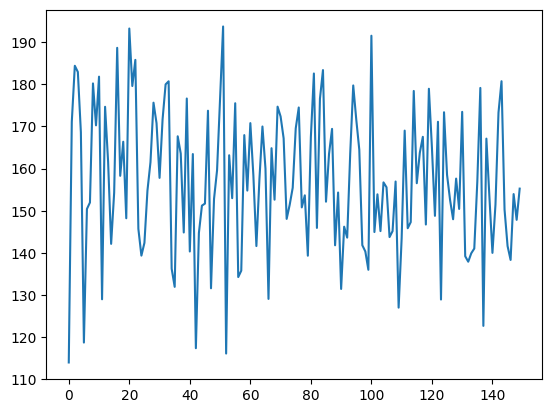

In [12]:
plt.plot(return_list)
plt.show()

In [13]:
"""
Rendering the environment
"""

test_env = et.load_test_env(checkpoint_path_dict, sa_env, 2)
renderer = Renderer(render_mode='episode', env=test_env.par_env.unwrapped)

Make env: mode: test, whole_days: 122, train_days: 106, val_days: 16, test_days: 16


Episode Time: (0, 575)
KPIs:
electrical_consumption_sum: 23.36
electrical_cost_sum: 103.97
discomfort_proportion: 0.88
discomfort_cold_proportion: 0.86
discomfort_hot_proportion: 0.02
BESS_electrical_consumption_contribution: 23.36 / 13.30, -0.76
BESS_electrical_cost_contribution: 103.97 / 50.66, -1.05
AC_control: 2 / 576, 0.00
BESS_control: 118 / 576, 0.20
washer_control: 576 / 576, 1.00


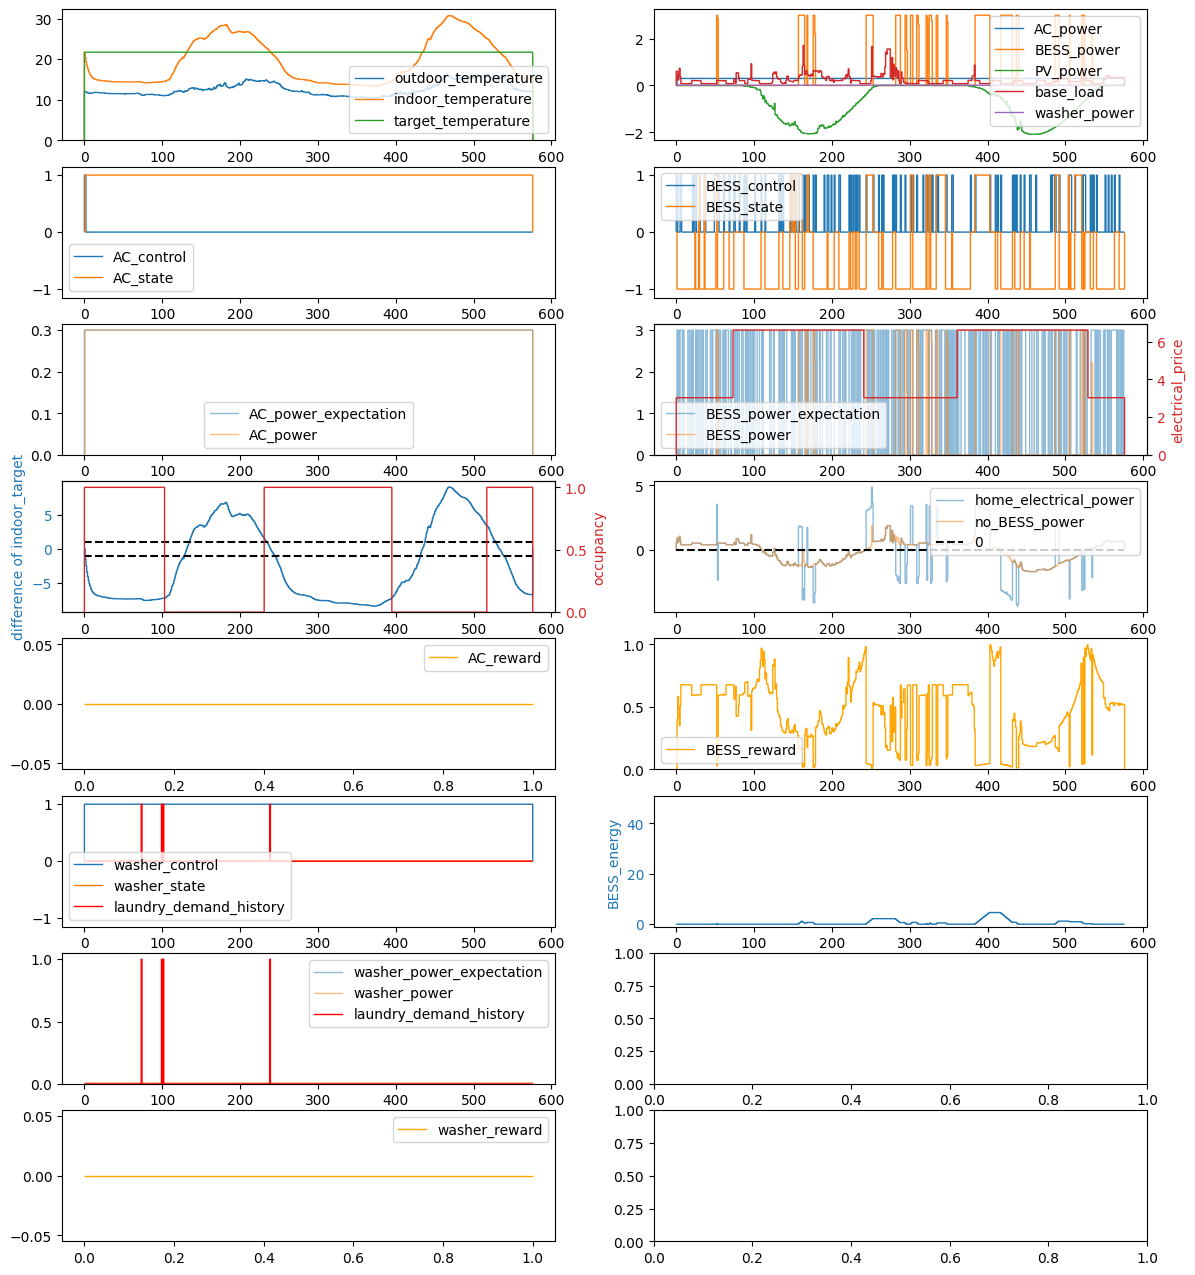

observation_shape: (1, 190), action_shape: (1, 6)
Episode Time: (576, 1151)
KPIs:
electrical_consumption_sum: 32.43
electrical_cost_sum: 147.96
discomfort_proportion: 0.97
discomfort_cold_proportion: 0.93
discomfort_hot_proportion: 0.04
BESS_electrical_consumption_contribution: 32.43 / 24.16, -0.34
BESS_electrical_cost_contribution: 147.96 / 109.49, -0.35
AC_control: 2 / 576, 0.00
BESS_control: 118 / 576, 0.20
washer_control: 576 / 576, 1.00


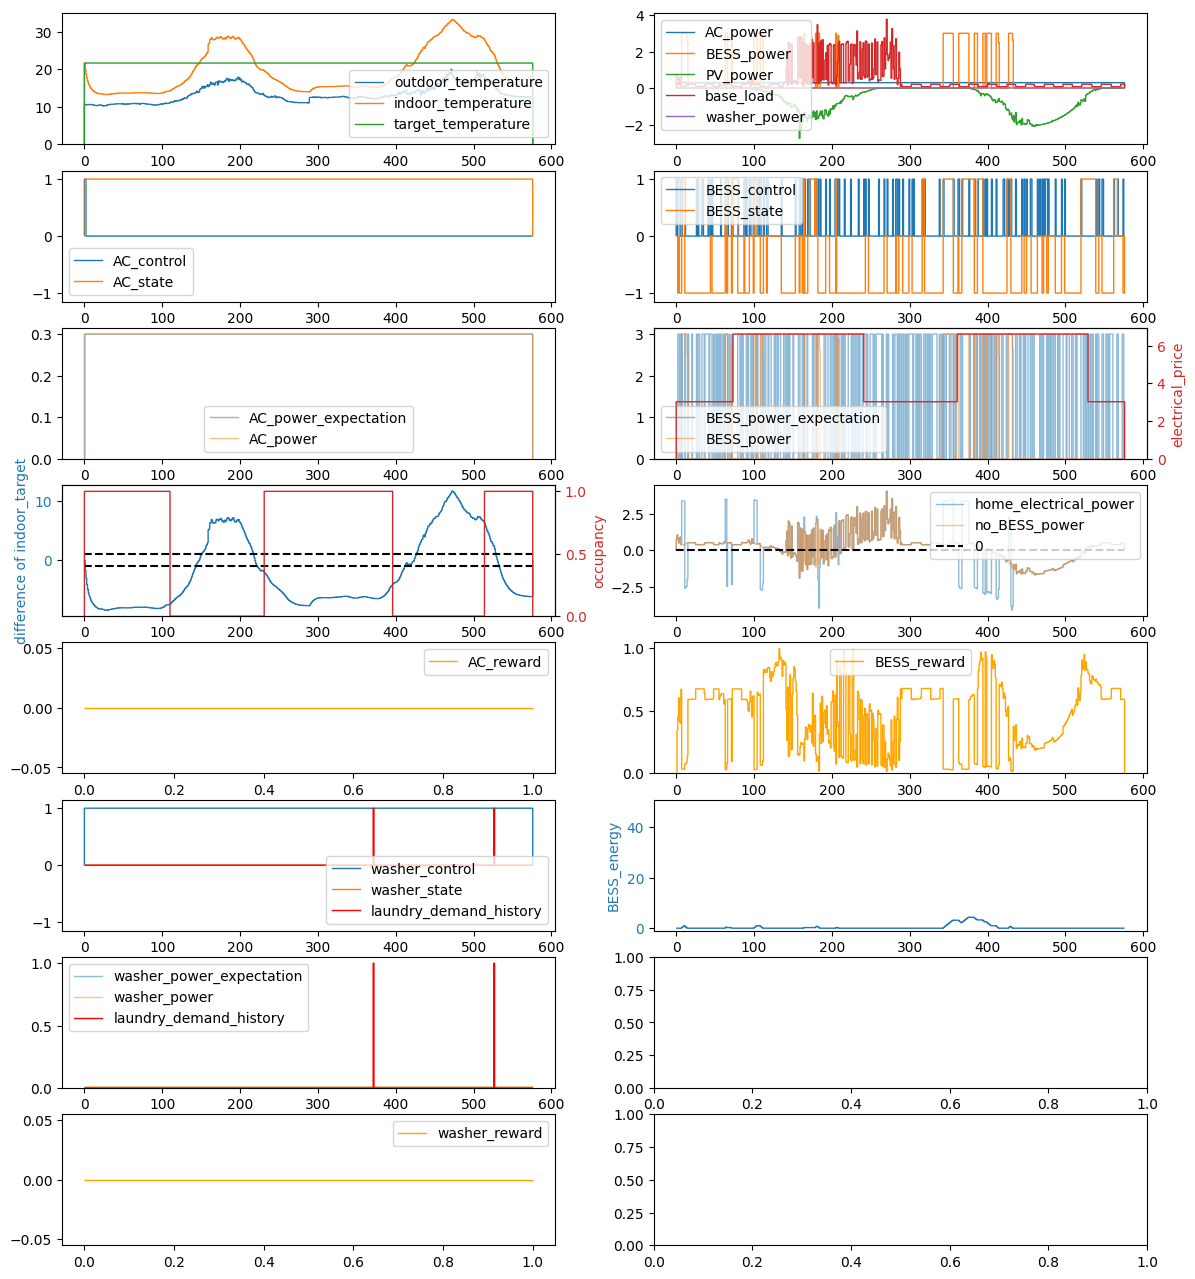

observation_shape: (1, 190), action_shape: (1, 6)
Episode Time: (1152, 1727)
KPIs:
electrical_consumption_sum: 23.43
electrical_cost_sum: 110.15
discomfort_proportion: 0.79
discomfort_cold_proportion: 0.63
discomfort_hot_proportion: 0.16
BESS_electrical_consumption_contribution: 23.43 / 14.77, -0.59
BESS_electrical_cost_contribution: 110.15 / 58.19, -0.89
AC_control: 2 / 576, 0.00
BESS_control: 115 / 576, 0.20
washer_control: 576 / 576, 1.00


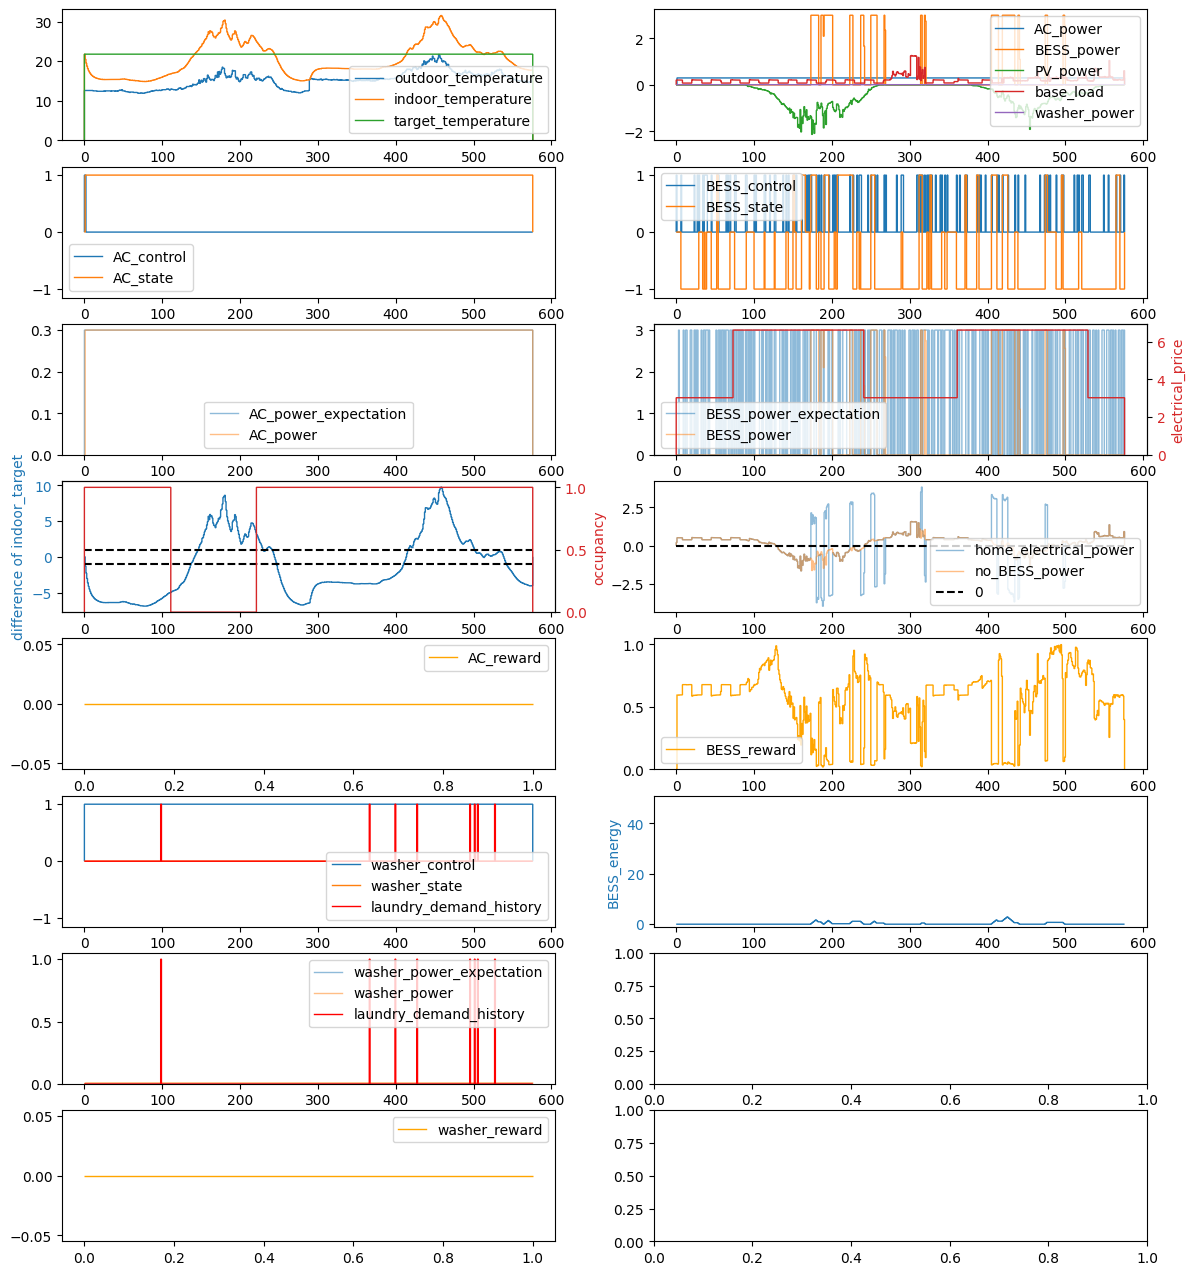

observation_shape: (1, 190), action_shape: (1, 6)


In [14]:
env = test_env
model = trained_agent
num_episodes = 3

obs, infos = env.reset()
for e in range(num_episodes):
    renderer.reset()
    terminations = [False]
    truncations = [False]
    while not any(terminations) and not any(truncations):
        act = model.take_action(obs)
        obs, rewards, terminations, truncations, infos = env.step(act)
        renderer.collect()
    renderer.render()
    print(f'observation_shape: {obs.shape}, action_shape: {act.shape}')
env.close()